In [1]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import cluster,mixture
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import scipy
import tkinter
from tkinter import messagebox

In [2]:
def data_prep(d_input, blank_keyword, svb_thres=10, empty_thres=0, cv_thres=5,rt_range=[0, 30], mz_range=[0, 1200], sn_thres=3, score_thres=0, area_thres=5000):
    drop_index = np.argwhere(np.asarray(d_input[d_input.columns[4:]].max(axis=1)) < area_thres).reshape(1,-1)
    d_thres = d_input.drop(drop_index[0])
    
    d_thres = d_thres[(d_thres['Average RT (min)'] > rt_range[0]) & (d_thres['Average RT (min)'] < rt_range[1])]
    d_thres = d_thres[(d_thres['Average m/z'] > mz_range[0]) & (d_thres['Average m/z'] < mz_range[1])]
    d_thres = d_thres[d_thres['Average sn'] >= sn_thres]
    d_thres = d_thres[d_thres['Average score'] >= score_thres]
    d_thres.reset_index(inplace=True)
    d_thres.drop(columns=['index'],inplace=True)
    
    col_blank = []
    for key in blank_keyword:
        col_app = [col for col in d_thres.columns if key in col]
        col_blank += col_app
    col_sample = [col for col in d_thres.columns if col not in col_blank]
    
    d_sample = d_thres[d_thres[col_sample[4:]].max(axis=1) / d_thres[col_blank].mean(axis=1) > svb_thres][col_sample]
    d_sample.reset_index(inplace=True)
    d_sample.drop(columns=['index'],inplace=True)
    
    trip_list = [list(i) for j, i in groupby(d_sample.columns[4:], lambda a: a.split('_')[1])]

    for triplicate in tqdm(trip_list):
        for index, row in d_sample[triplicate].iterrows():
            if (row == 0).sum() > empty_thres:
                d_sample.loc[index, triplicate] = 0
            elif row.std() / row.mean() > cv_thres:
                d_sample.loc[index, triplicate] = 0 #If delete or reduce all number to avg?
    d_sample = d_sample[(d_sample.iloc[:,4:]!=0).sum(1) > 3]
    
    
    return d_sample

In [3]:
def ms_cluster(d_input, d_reduce=True, d_reduce_method='tsne', perplexity=50, cluster_method='dbscan',eps=0.8,min_samples=10):
    if d_reduce == True:
        if d_reduce_method == 'tsne':
            model = TSNE(learning_rate=100,perplexity=50,n_iter=1000) #Tune perplexity and n_iter
            transformed = model.fit_transform(d_norm)
            X=transformed.copy()
    elif d_reduce == False:
        X=d_norm.copy()
    if cluster_method == 'dbscan':
        dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = dbscan.labels_
        unique_labels = set(dbscan.labels_)

        for i,k in enumerate(unique_labels):
            indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
            sns.clustermap(d_norm.iloc[indexlist].values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False,figsize=(5,5))
            plt.title(str(dbscan)+'label='+ str(k))
            plt.show()

        d_init = d_sample.copy()
        d_label = d_init.loc[d_norm.index]
        d_label.insert(4,"label", dbscan.labels_.tolist())
    
    return d_label, d_norm

In [4]:
def trend_calc(df, min_size, visual=True):
    """This function calculates clustering based on the pearson correlation.
    It takes in a dataframe and a user defined value for what qualifies as a cluster.
    User can choose whether or not to have a visual plot of the scatter with True/False."""
    cluster = [] # individual cluster holder
    cluster_sum = [] # total clusters
    drop_list = [] # rows that are dropped from the df
    noise = [] # list for containing noise features
    while len(df) > 0:
        for row in range(len(df)):
            feature_1 = df.iloc[0]
            feature_2 = df.iloc[row]
            corr, p_val = scipy.stats.pearsonr(df.iloc[0, 2:], df.iloc[row, 2:])
            if p_val < 0.05:
                drop_list.append(row)
                cluster += [feature_2]
            else:
                pass
        if len(cluster) <= min_size:
            noise += [cluster]
            cluster = []
        else:
            cluster_sum += [cluster]
            cluster = []
        df = df.drop(drop_list)
        df = df.reset_index(drop=True)
        drop_list = []
    append_list = []
    for i in range(len(cluster_sum)):
        for j in range(len(cluster_sum[i])):
            cluster_sum[i][j].loc['Score']= i
            listing = np.array(cluster_sum[i][j])
            append_list.append(listing)
    cluster_df = pd.DataFrame(append_list)
    append_list2 = []
    for k in range(len(noise)):
        for l in range(len(noise[k])):
            noise[k][l].loc['Score']= -1
            listing2 = np.array(noise[k][l])
            append_list2.append(listing2)
    noise_df = pd.DataFrame(append_list2)
    final_df = pd.concat([cluster_df, noise_df])
    final_df = final_df.reset_index(drop=True)
    if visual == True:
        rt=[]
        mz=[]
        for i in range(len(cluster_sum)):
            for j in range(len(cluster_sum[i])):
                rt.append(cluster_sum[i][j].loc['RT'])
                mz.append(cluster_sum[i][j].loc['MZ'])
            plt.scatter(rt,mz,label=i)
            rt=[]
            mz=[]
        rt2=[]
        mz2=[]
        for k in range(len(noise)):
            rt2.append(noise[k][0].loc['RT'])
            mz2.append(noise[k][0].loc['MZ'])
        plt.scatter(rt2,mz2,label='noise')
        plt.xlabel('RT')
        plt.ylabel('m/z')
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    else:
        pass
    return final_df

In [5]:
dataframe = input("Enter what data you want to use:")
## i.e. '../example_data/clustering/sample1114.csv'
d_ms = pd.read_csv(dataframe)

Enter what data you want to use:../example_data/clustering/sample1114.csv


In [6]:
d_ms = d_ms.rename(columns={'Average Rt(min)': 'Average RT (min)', 'Average Mz': 'Average m/z', 'S/N average': 'Average sn'})
d_ms.insert(3, "Average score", 1)

In [7]:
keys=['CEC','Blank','ISTD','Wash','Shutdown']

In [8]:
d_sample = data_prep(d_ms,keys,rt_range = [1,30], mz_range = [200,800], area_thres=500)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.83s/it]


In [9]:
normalization = input("Choose normalization method: linear, zscore, log: ")
## i.e 'linear'
select_keyword = input("Any keywords to select data by? if not enter 'no': ")
## ie.e 'SR520-Cal;
col_select = []

d_clu = pd.DataFrame()
if select_keyword == 'no':
    dclu = d_sample
else:
    for key in select_keyword:
        col_app = [col for col in d_sample.columns if key in col]
        col_select += col_app
    d_clu = d_sample[col_select]

c_data = d_clu.values
c_norm = []
for row in c_data:
    if normalization == 'linear':
        c_norm.append(row/max(row))
    elif normalization == 'zscore':
        c_norm.append((row-np.mean(row))/np.std(row))
    elif normalization == 'log':
        row[row==0]=1
        c_norm.append(np.log10(row)/np.log10(max(row)))
c_norm = np.asarray(c_norm)
d_norm = pd.DataFrame(c_norm)
d_norm['index']=d_sample.index
d_norm.set_index('index',inplace=True)
d_norm.dropna(how='all',inplace=True)



Choose normalization method: linear, zscore, log: linear
Any keywords to select data by? if not enter 'no': SR520-Cal


which model do you want to use? enter 'ms_cluster' or 'trend_cluster': ms_cluster
do you want to use reduction? enter 'yes' or no': yes
what reduction method would you like to use?: tsne
what perplexity would you like the model to use?: 50
which cluster method would you like to use?: dbscan
enter eps: 0.8
enter minimum samples for cluster consideration: 10


C:\Users\nozom\miniconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


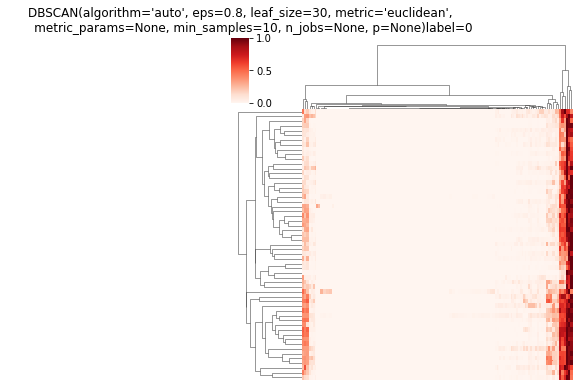

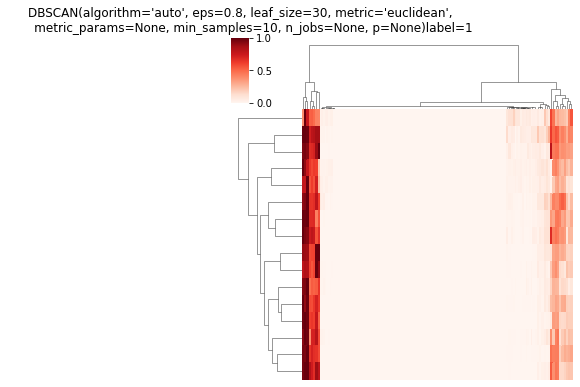

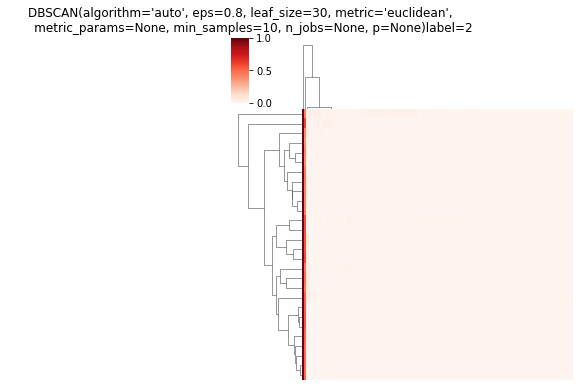

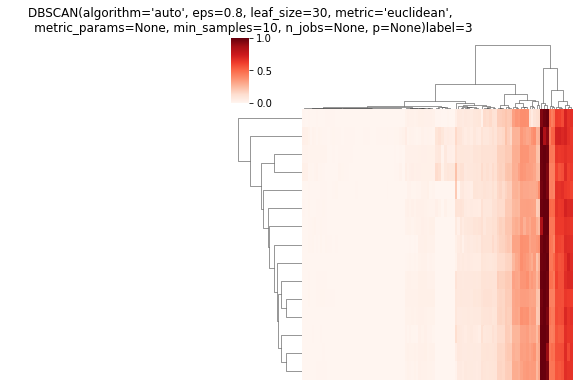

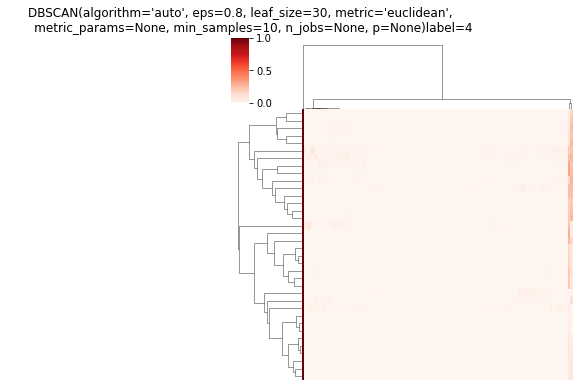

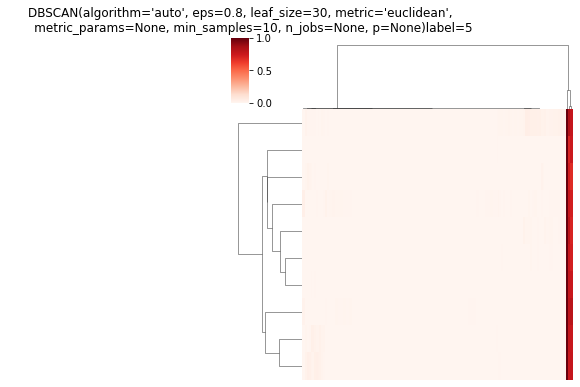

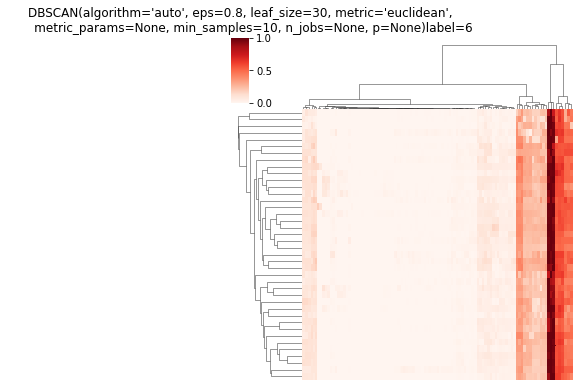

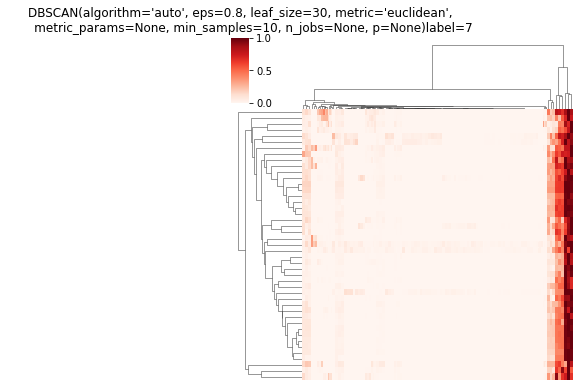

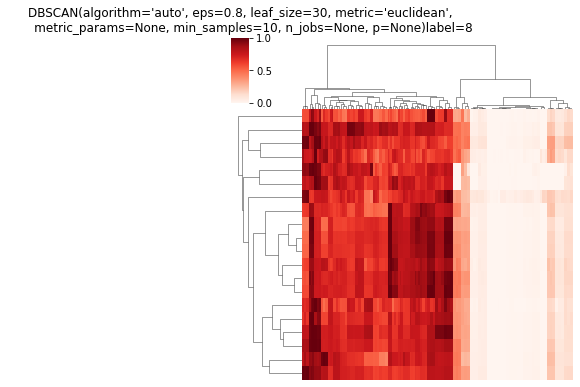

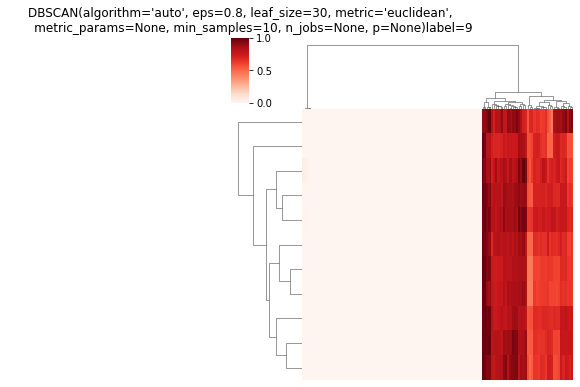

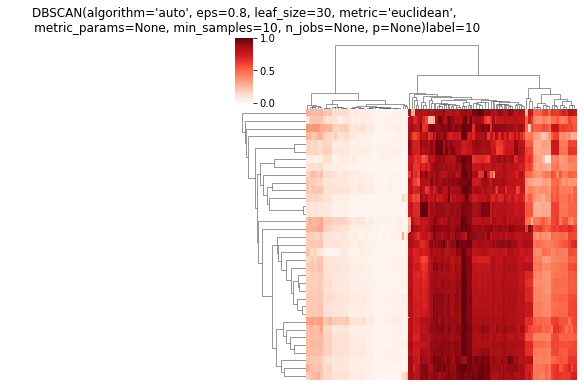

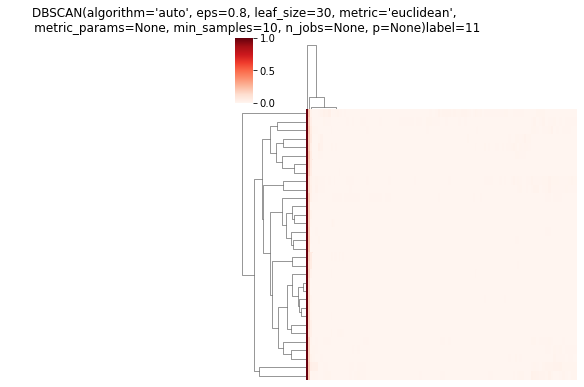

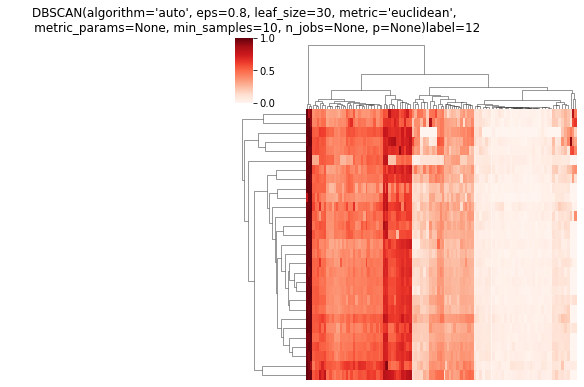

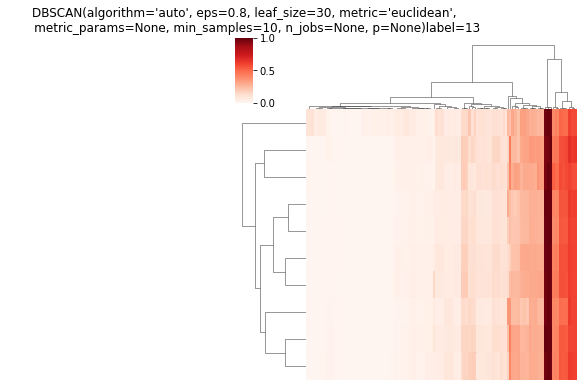

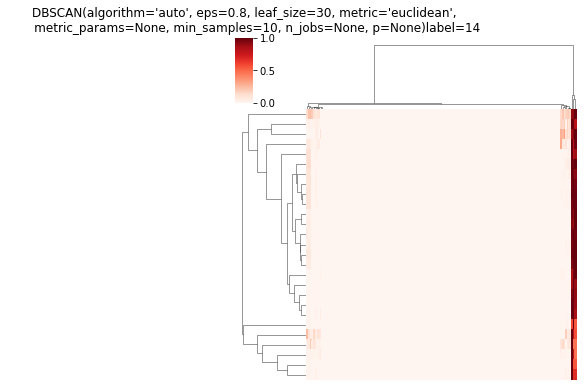

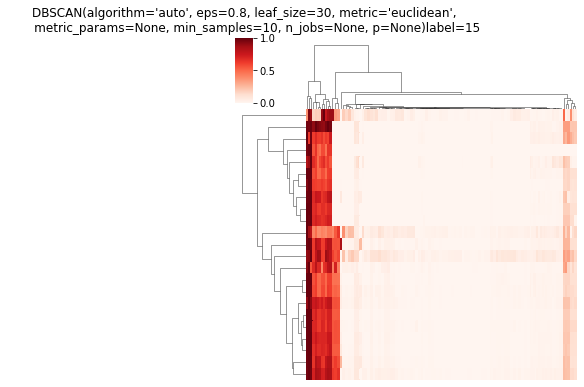

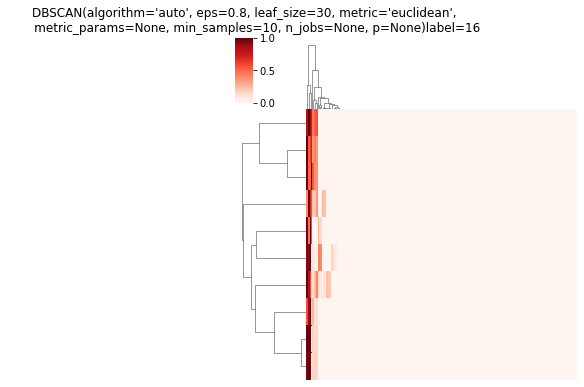

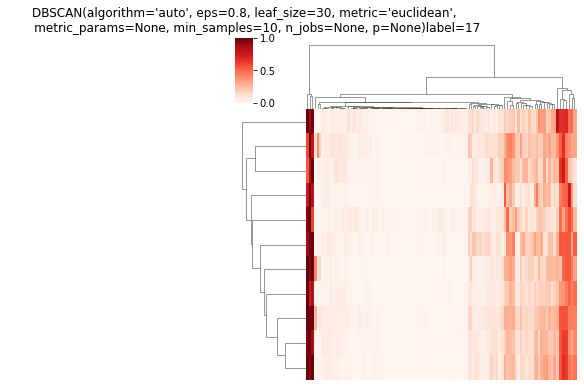

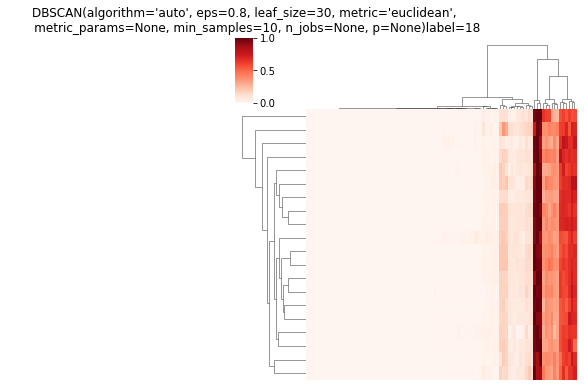

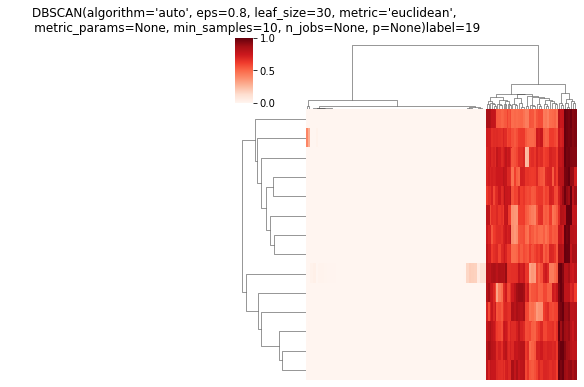

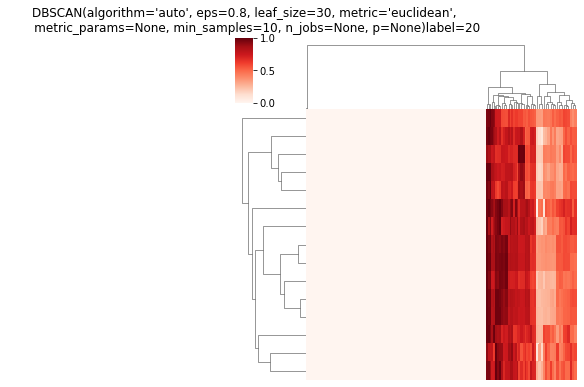

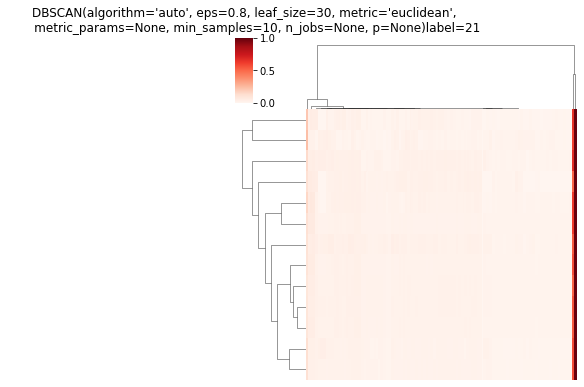

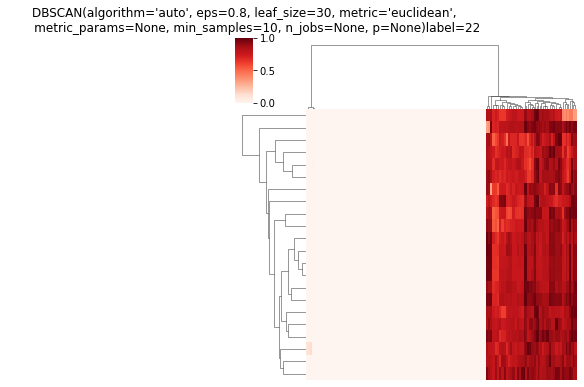

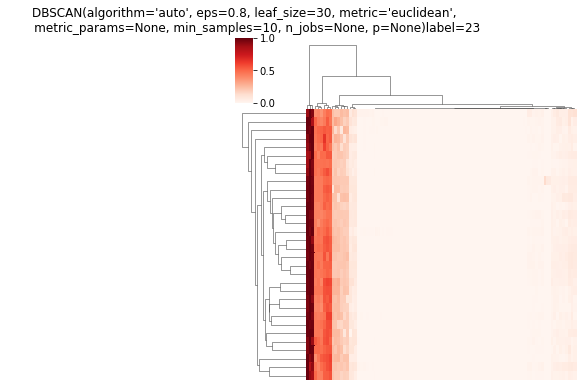

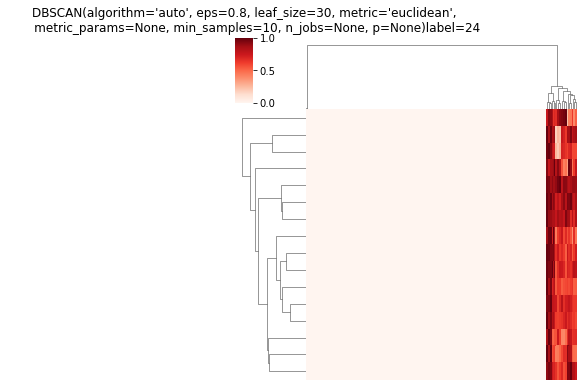

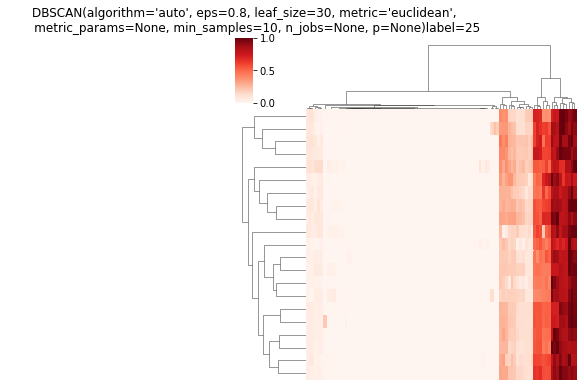

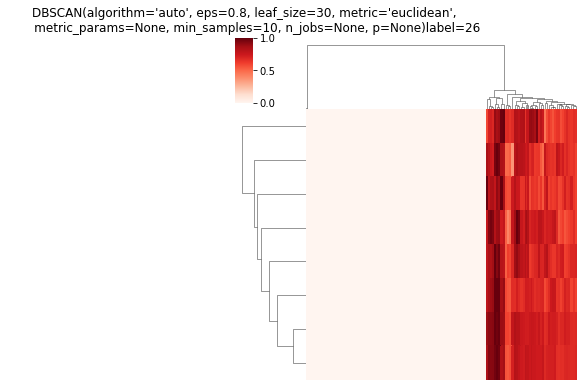

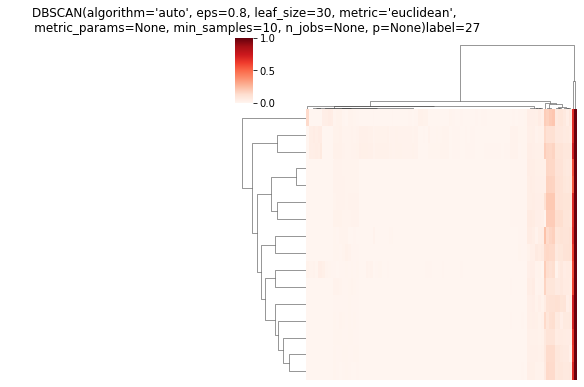

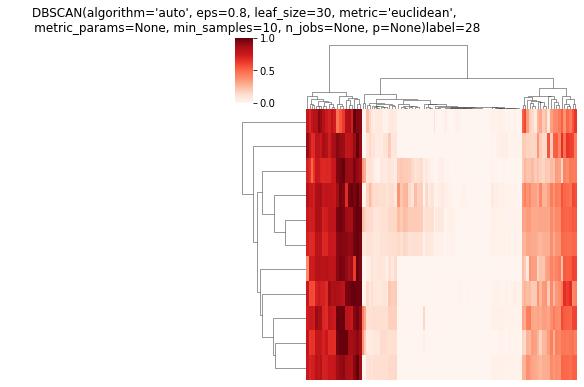

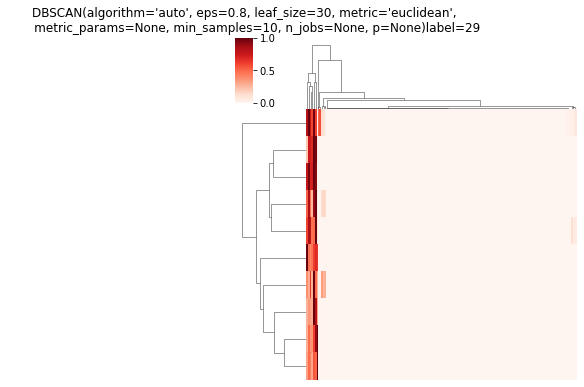

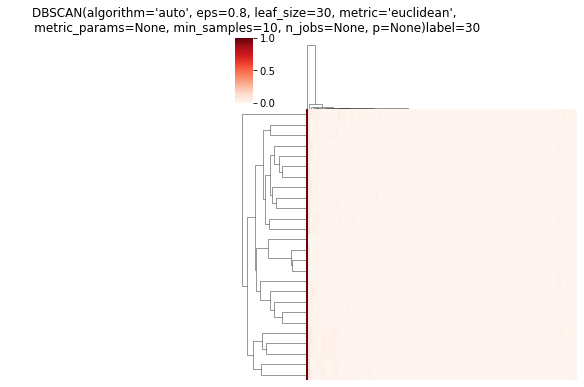

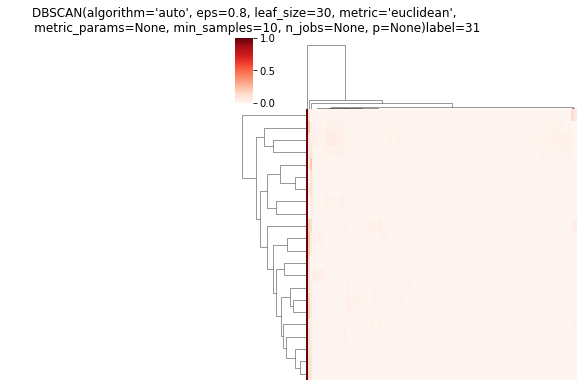

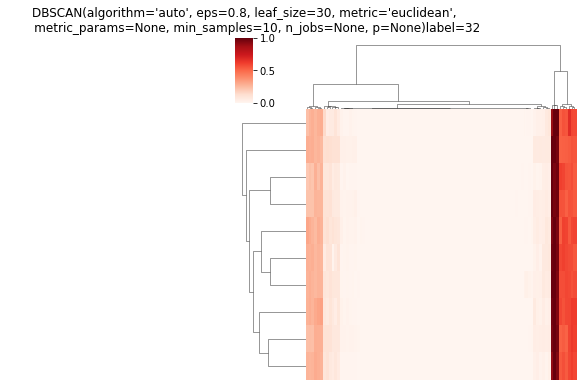

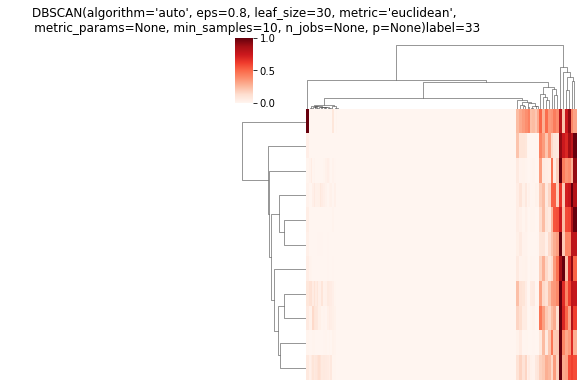

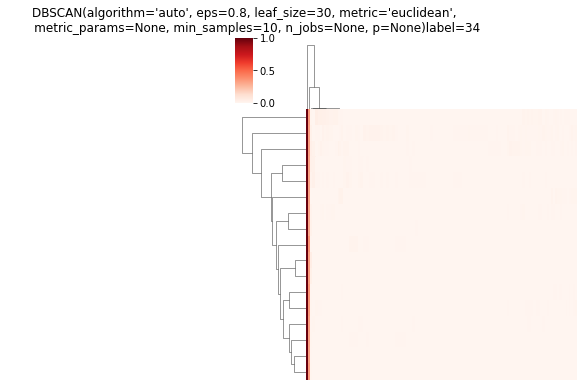

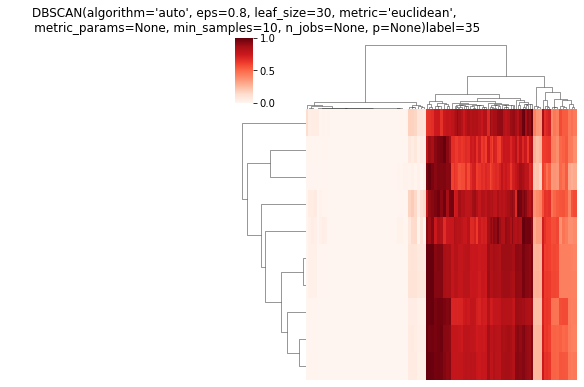

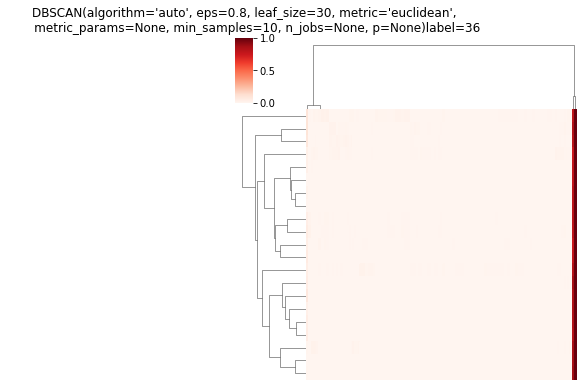

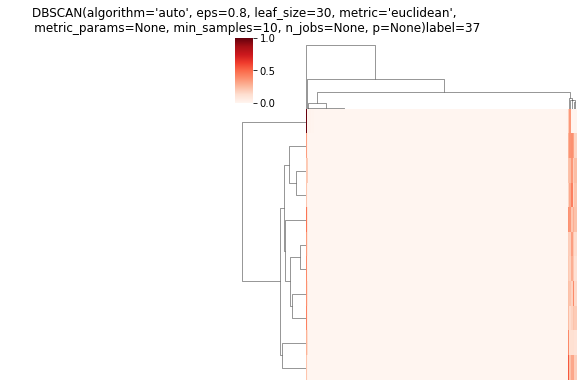

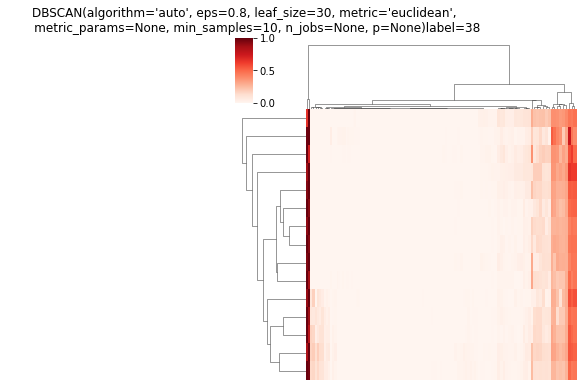

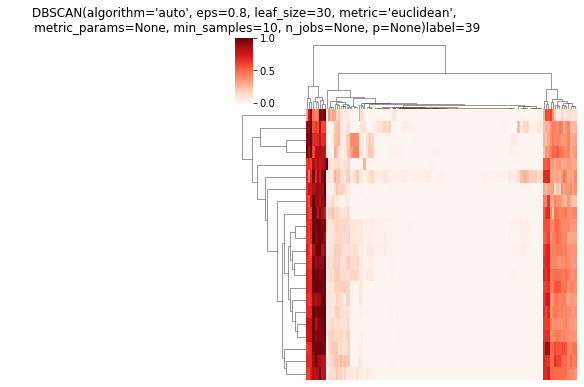

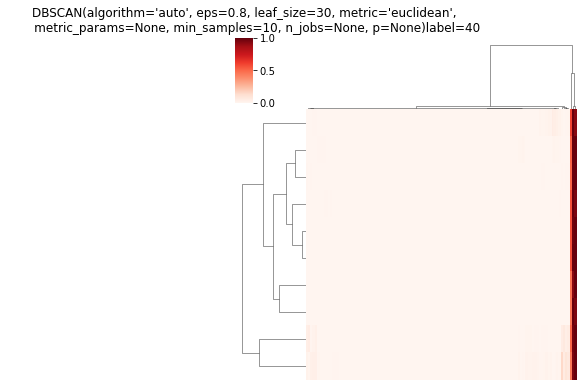

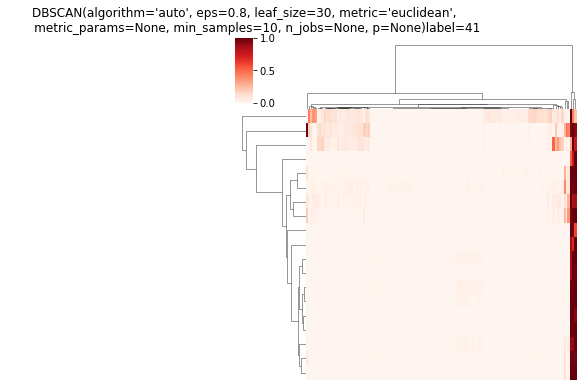

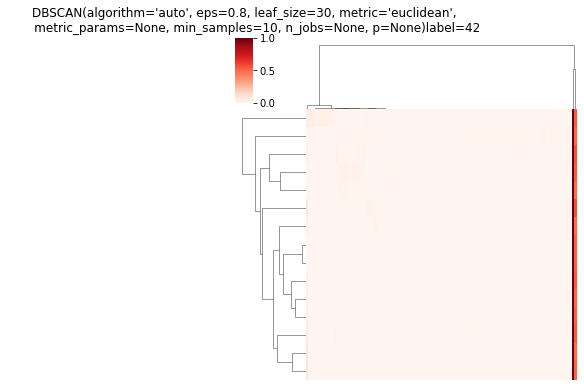

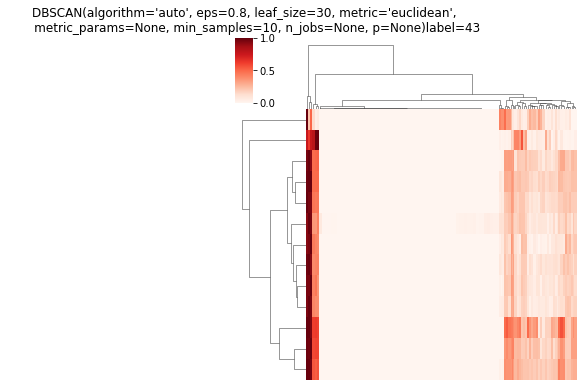

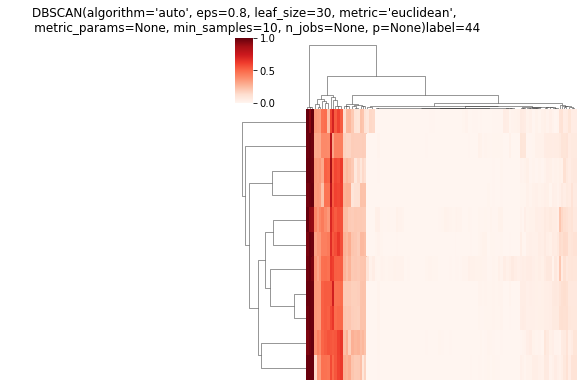

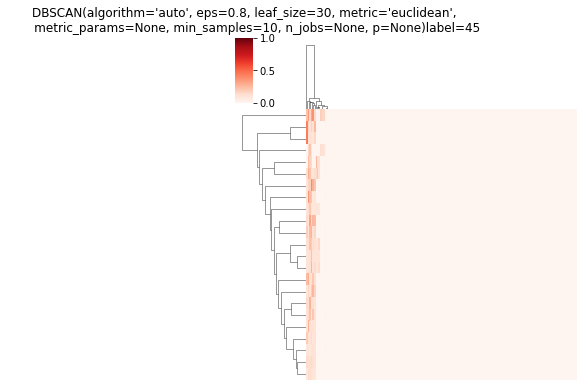

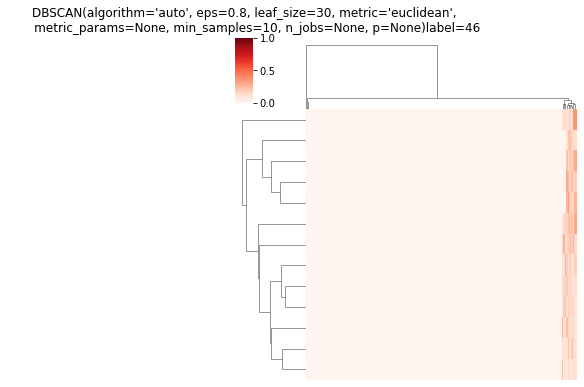

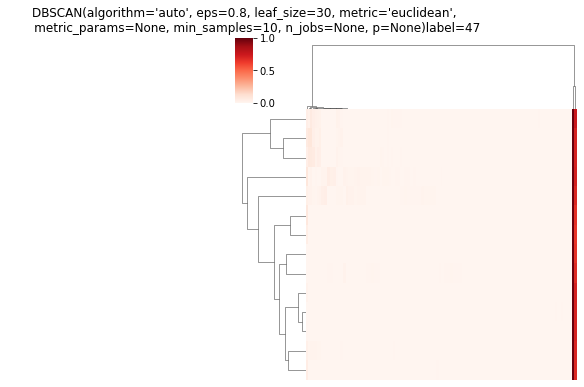

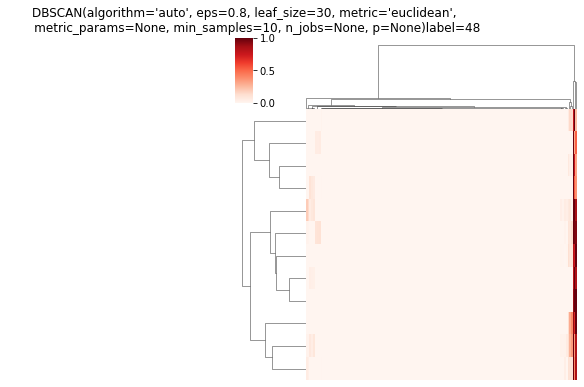

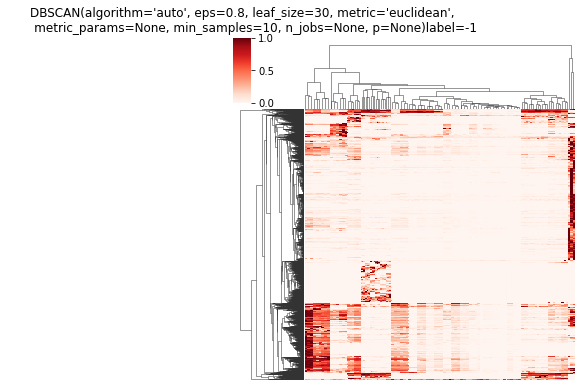

In [15]:
model = input("which model do you want to use? enter 'ms_cluster' or 'trend_cluster': ")
if model == 'ms_cluster':
    reduction = input("do you want to use reduction? enter 'yes' or no': " )
    if reduction == 'yes':
        reduction_method = input("what reduction method would you like to use?: ")
        ## i.e. 'tsne'
        perplexity = int(input("what perplexity would you like the model to use?: "))
        ## i.e. 50
        method = input("which cluster method would you like to use?: ")
        ## i.e.e 'dbscan'
        eps = float(input("enter eps: "))
        ## i.e. 0.8
        min_samples = int(input("enter minimum samples for cluster consideration: "))
        ## i.e. 10
        ms_cluster(d_norm, True, reduction_method, perplexity , method, eps, min_samples)
    else:
        perplexity = int(input("what perplexity would you like the model to use?: "))
        ## i.e. 50
        method = input("which cluster method would you like to use?: ")
        ## i.e.e 'dbscan'
        eps = int(input("enter eps: "))
        ## i.e. 0.8
        min_samples = int(input("enter minimum samples for cluster consideration: "))
        ## i.e. 10
        ms_cluster(d_norm, False, 'tsne', perplexity , method, eps, min_samples) 
elif model == 'trend_cluster':
    d_norm.insert(0,"RT", d_label['Average RT (min)'].tolist())
    d_norm.insert(1,"MZ", d_label['Average m/z'].tolist())
    d_norm = d_norm.dropna()
    d_norm = d_norm.reset_index(drop=True)
    minimum = int(input("enter minimum samples for cluster consideration: "))
    trend_calc(d_norm, minimum, visual=True)     
else:
    pass